In [ ]:
# Kiểm tra xem file nguồn đã tồn tại trong bộ nhớ chưa
import os

if os.path.exists('HomeTest 1 - KPMG Data'):
    print('File exists')
else:
    print('File does not exist')

File does not exist


In [ ]:
# Tải file nguồn lên môi trường Colab
from google.colab import files
uploaded = files.upload()

Saving HomeTest 1 - KPMG Data.xlsx to HomeTest 1 - KPMG Data.xlsx


In [ ]:
# Tạo Dataframe từ file data
import pandas as pd
df = pd.read_excel('HomeTest 1 - KPMG Data.xlsx')

In [ ]:
# Làm sạch dữ liệu
df.drop_duplicates()
df = df[df["order_status"] == "Approved"]

In [ ]:
# Xóa các cột không cần thiết
xoa = ['product_id','online_order','brand','product_line','product_class','product_size','list_price','standard_cost','product_first_sold_date','order_status']
df.drop(xoa, inplace = True, axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19821 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    19821 non-null  int64         
 1   customer_id       19821 non-null  int64         
 2   transaction_date  19821 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 619.4 KB


In [ ]:
# Nhập các thư viện cần dùng
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
# Tạo cột Cohort month: Lấy tháng dưới dạng mm-yyyy từ transaction_date cũ nhất theo từng customer_id
# cột min chứa ngày order sớm nhất theo từng customer_id:
df['min'] = df.groupby('customer_id').transaction_date.transform(np.min)
# Cột cohort_month lấy tháng từ ngày min:
df['cohort_month'] = df['min'].dt.to_period('M')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19821 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    19821 non-null  int64         
 1   customer_id       19821 non-null  int64         
 2   transaction_date  19821 non-null  datetime64[ns]
 3   min               19821 non-null  datetime64[ns]
 4   cohort_month      19821 non-null  period[M]     
dtypes: datetime64[ns](2), int64(2), period[M](1)
memory usage: 929.1 KB


In [ ]:
# Tạo cột Cohort Index: tính số tháng giữa transaction_date hiện tại với transaction_date sớm nhất theo từng transaction_date
# min - transaction_date tính bằng tháng
df['Cohort_Index'] = ((df['transaction_date'] - df['min'])/np.timedelta64(1, 'M'))
df['Cohort_Index'] = df['Cohort_Index'].astype(int) +1
df

,transaction_id,customer_id,transaction_date,min,cohort_month,Cohort_Index
0,1,2950,2017-02-25,2017-02-25,2017-02,1
1,2,3120,2017-05-21,2017-01-20,2017-01,4
2,3,402,2017-10-16,2017-01-29,2017-01,9
3,4,3135,2017-08-31,2017-02-08,2017-02,7
4,5,787,2017-10-01,2017-01-24,2017-01,9
...,...,...,...,...,...,...
19995,19996,1018,2017-06-24,2017-01-25,2017-01,5
19996,19997,127,2017-11-09,2017-01-03,2017-01,11
19997,19998,2284,2017-04-14,2017-04-06,2017-04,1
19998,19999,2764,2017-07-03,2017-02-27,2017-02,5


In [ ]:
# Nhóm customer_id theo cả Cohort month và Cohort Index và đếm số lượng distinct customer_id
cohort = df.groupby(['cohort_month','Cohort_Index']).agg(customer_count=('customer_id','nunique')).sort_values(['cohort_month','Cohort_Index']).reset_index()
cohort

,cohort_month,Cohort_Index,customer_count
0,2017-01,1,1347
1,2017-01,2,490
2,2017-01,3,519
3,2017-01,4,502
4,2017-01,5,477
...,...,...,...
73,2017-10,2,11
74,2017-10,3,3
75,2017-11,1,13
76,2017-11,2,3


In [ ]:
# Xoay bảng để trực quan hóa heatmap
cohort_pivot = cohort.pivot(index='cohort_month',
                      columns ='Cohort_Index',
                      values = 'customer_count')
cohort_pivot

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-01,1347.0,490.0,519.0,502.0,477.0,492.0,526.0,503.0,494.0,514.0,468.0,288.0
2017-02,800.0,307.0,300.0,293.0,291.0,292.0,297.0,308.0,321.0,303.0,158.0,NaN
2017-03,484.0,163.0,183.0,160.0,186.0,172.0,196.0,193.0,178.0,115.0,NaN,NaN
2017-04,337.0,109.0,139.0,146.0,131.0,141.0,133.0,123.0,82.0,NaN,NaN,NaN
2017-05,213.0,88.0,85.0,78.0,83.0,61.0,77.0,55.0,NaN,NaN,NaN,NaN
2017-06,123.0,43.0,45.0,45.0,51.0,49.0,32.0,NaN,NaN,NaN,NaN,NaN
2017-07,77.0,27.0,26.0,30.0,39.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,51.0,17.0,24.0,16.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,24.0,8.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Tính tỷ lệ giữ chân của tháng thứ x = số người mua hàng tháng thứ x / số người mua hàng tháng thứ 1 * 100
first_month = cohort_pivot[cohort_pivot.columns[0]]
retention_rate = cohort_pivot.divide(first_month, axis = 0)
retention_rate.round(2)

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-01,1.0,0.36,0.39,0.37,0.35,0.37,0.39,0.37,0.37,0.38,0.35,0.21
2017-02,1.0,0.38,0.38,0.37,0.36,0.36,0.37,0.38,0.40,0.38,0.20,NaN
2017-03,1.0,0.34,0.38,0.33,0.38,0.36,0.40,0.40,0.37,0.24,NaN,NaN
2017-04,1.0,0.32,0.41,0.43,0.39,0.42,0.39,0.36,0.24,NaN,NaN,NaN
2017-05,1.0,0.41,0.40,0.37,0.39,0.29,0.36,0.26,NaN,NaN,NaN,NaN
2017-06,1.0,0.35,0.37,0.37,0.41,0.40,0.26,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.35,0.34,0.39,0.51,0.16,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.33,0.47,0.31,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.33,0.29,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Setup the figure size
plt.figure(figsize=(16, 10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

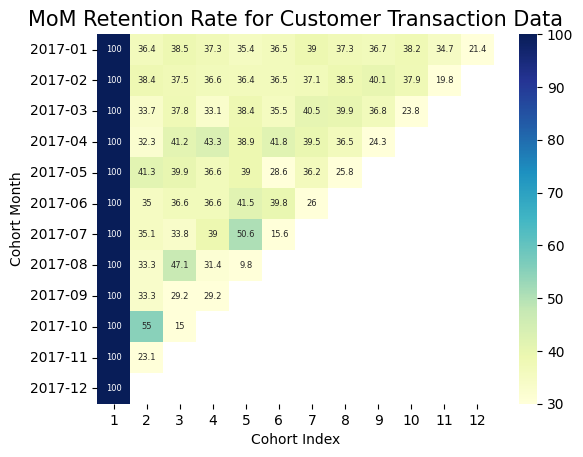

In [ ]:
# Tạo biểu đồ heat map
sns.heatmap((retention_rate*100).round(1), annot=True, fmt= 'g',cmap='YlGnBu', annot_kws={'size': 6}, vmin = 30 , vmax = 100)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation= 'horizontal')
plt.title('MoM Retention Rate for Customer Transaction Data', fontsize = 15)
plt.show()

Biểu đồ này cho thấy màu sắc tổng thể tương đối đồng nhất, tỷ lệ giữ chân trung bình là 35% trên toàn bộ biểu đồ. Tỷ lệ này đang ở mức khá cao, cho biết rằng hiện tại khách hàng đánh giá cao về sản phẩm và họ đang mang lại nguồn doanh thu khá bền vững cho doanh nghiệp.

- Tỷ lệ giữ chân khách hàng xuống thấp nhất là 9,8% vào tháng thứ 3 của nhóm khách hàng tham gia lần đầu vào tháng 8/2017. Tỷ lệ giữ chân cao nhất đạt 55% vào tháng thứ 2 tham gia của nhóm khách hàng tham gia lần đầu vào tháng 10/2017.
- Có thể thấy xu hướng mua hàng của nhóm khách hàng tham gia lần đầu vào tháng 10/2017 là đồng nhất và có sự khác biệt lớn với những nhóm khách hàng khác (Tỷ lệ giữ chân ở tháng thứ 2 cao, nhưng giảm xuống rất thấp ở tháng thứ 3).

- Nhìn chung, tỷ lệ giữ chân của những nhóm khách hàng tham gia lần đầu vào những tháng đầu năm (tháng 1,2,3,4) được duy trì tương đối ổn định ở mức 35-42%. Với những nhóm khách hàng tham gia lần đầu vào tháng 7 đến tháng 12, tỷ lệ giữ chân thấp hơn hẳn và có biên độ dao động khá lớn: thường ở mức khoảng 20-33% nhưng cũng có một vài tháng vượt trên 45% và những tháng xuống dưới 16%

- Tổng đơn hàng trong tháng 12/2017 chỉ chiếm 8,2% trên toàn bộ số đơn hàng trong năm, vì vậy, tỷ lệ giữ chân của những tháng cuối cùng ở tất cả các nhóm khách hàng đều thấp hơn nhiều (chỉ bằng khoảng 1/2 so với tỷ lệ trung bình của nhóm khách hàng đó) so với những tháng khác trong toàn bộ quá trình tham gia của họ.

- Thông thường, các tháng cuối năm sẽ là cao điểm mua sắm tại thị trường Việt Nam. Do đó, tỷ lệ đơn hàng trong tháng này chỉ chiếm 8,2% đang cho thấy sự bất thường. Để tăng tỷ lệ đơn hàng trong tháng 12 cũng như tăng tỷ lệ giữ chân khách hàng, doanh nghiệp cần có những ưu đãi, khuyến mại phù hợp đối với từng phân khúc khách hàng nhằm kích cầu mua sắm và có thêm những khách hàng mới.